In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1=nn.Conv2d(1,6,kernel_size=5, stride=1,padding=2) ## 28x28 - > 28x28
        self.relu=nn.ReLU()
        self.pool=nn.AvgPool2d(kernel_size=2,stride=2) ## 28x28->14x14
        self.conv2=nn.Conv2d(6,16,kernel_size=5,stride=1) ## 14x14-->10x10
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,x):
        x=self.pool(self.relu(self.conv1(x))) ## conv1->Relu->Pool
        x=self.pool(self.relu(self.conv2(x))) ## Conv2->Relu->Pool
        x=x.view(-1,16*5*5) ## Flatten
        x=self.relu(self.fc1(x))  ## fully connected layer1 -> Relu
        x=self.relu(self.fc2(x)) ## fully connected layer2 -> Relu
        x=self.fc3(x)    ## fully connected layer 3
        return x
    


In [6]:
batch_size=64
epochs=10
learning_rate=0.001

In [5]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,transform=transform,download=True)
test_dataset=torchvision.datasets.MNIST(root='./data',train=False,transform=transform,download=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

100%|██████████| 9.91M/9.91M [00:28<00:00, 342kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 23.4MB/s]


In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'gpu')
model=LeNet().to(device=device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [11]:
## Training Loop
train_losses,test_accuracies=[],[]
for epoch in range(epochs):
    model.train()
    running_loss=0.0
    for images,labels in train_loader:
        images,labels =images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    avg_loss=running_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss={avg_loss:.4f}")

    ## Evaluatoin
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    accurracy=100*correct/total
    test_accuracies.append(accurracy)
    print(f"Accurracy on test set:{accurracy:.2f}%")


Epoch 1/10, Loss=0.2575
Accurracy on test set:97.74%
Epoch 2/10, Loss=0.0762
Accurracy on test set:98.44%
Epoch 3/10, Loss=0.0554
Accurracy on test set:98.62%
Epoch 4/10, Loss=0.0431
Accurracy on test set:98.83%
Epoch 5/10, Loss=0.0375
Accurracy on test set:98.75%
Epoch 6/10, Loss=0.0323
Accurracy on test set:98.99%
Epoch 7/10, Loss=0.0274
Accurracy on test set:98.97%
Epoch 8/10, Loss=0.0233
Accurracy on test set:99.01%
Epoch 9/10, Loss=0.0199
Accurracy on test set:99.09%
Epoch 10/10, Loss=0.0183
Accurracy on test set:99.01%


Text(0.5, 1.0, 'Test Accurracy over epochs')

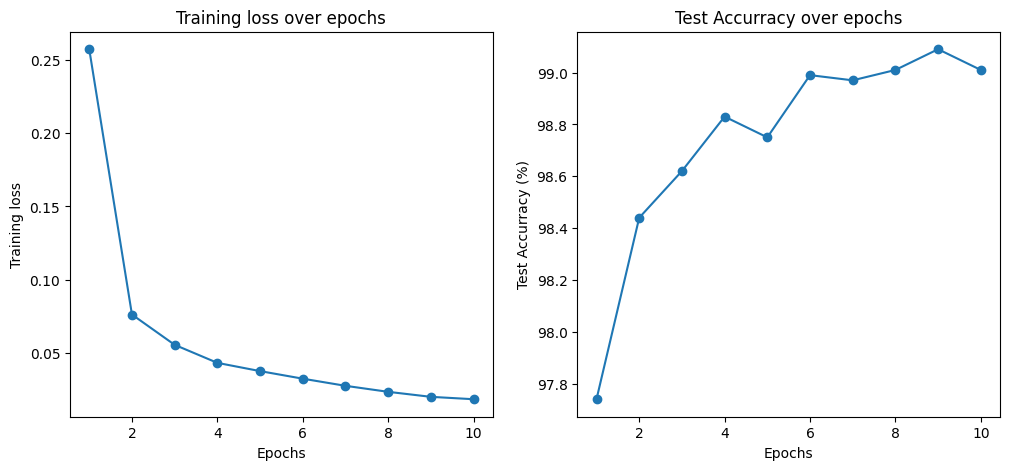

In [13]:
## Plot Accuraccy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,epochs+1),train_losses,marker='o',linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')

## 
plt.subplot(1,2,2)
plt.plot(range(1,epochs+1),test_accuracies,marker='o',linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Test Accurracy (%)')
plt.title('Test Accurracy over epochs')

In [18]:
## Infernece function
def predict_image(image):
    model.eval()  # put model in evaluation mode
    with torch.no_grad():  # disable gradient tracking
        image = image.to(device).unsqueeze(0)  # add batch dimension [1, C, H, W]
        output = model(image)  # forward pass
        _, predicted = torch.max(output, 1)  # get index of highest logit
        return predicted.item()  # return as Python integer

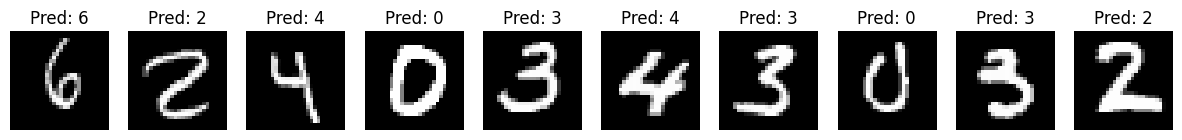

In [19]:
## visualizing predictions
# Get one batch of samples from test_loader
samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)

# Predict first 10 images
predictions = [predict_image(img) for img in samples[:10]]

# Plot the images and predictions
fig, axes = plt.subplots(1, 10, figsize=(15, 4))  # <-- fixed typo: subplot → subplots
for i, ax in enumerate(axes):
    ax.imshow(samples[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')  # move channels to last dim
    ax.set_title(f"Pred: {predictions[i]}")
    ax.axis('off')
plt.show()
